# **PROJECT:** Performance of Players Analytic for Each Club



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Players

In [ ]:
players = pd.read_csv("players.csv")
players

In [ ]:
players_cleaned = players.dropna(subset=['position'])

In [ ]:
# players.info()
print(players.isnull().sum())
print(players.duplicated().sum())

In [ ]:
players.info()

In [ ]:
players['sub_position'] = players['sub_position'].replace({'Second Striker': 'Striker', 'Centre-Forward': 'Striker'})
print(players[['sub_position', 'name']])

In [ ]:
players["date_of_birth"] = players["date_of_birth"].str.split(" ").str[0]


In [ ]:
players['date_of_birth'] = pd.to_datetime(players["date_of_birth"], format="%Y-%m-%d")
players.info()

In [ ]:
# Dropping the column
players_cleaned = players.drop(columns=['contract_expiration_date','agent_name'])
players_cleaned = players_cleaned.dropna()
print(players_cleaned.isnull().sum())

In [ ]:
abs(players_cleaned.select_dtypes(exclude='object').corr())

# Appearances

In [ ]:
appearances = pd.read_csv("appearances.csv")
appearances

In [ ]:
print(appearances.isnull().sum())
print(appearances.duplicated().sum())

In [ ]:
# Merge appearances and players DataFrames on player_id
merged_df = appearances.merge(players[['player_id', 'name']], how='left', on='player_id')

appearances_cleaned = appearances

# Fill null values in player_name with the merged values
appearances_cleaned['player_name'] = merged_df['name'].fillna(method='ffill')

print(appearances_cleaned.isnull().sum())
print(appearances_cleaned.duplicated().sum())

In [ ]:
appearances_cleaned['date'] = pd.to_datetime(appearances_cleaned["date"], format="%Y-%m-%d")
appearances_cleaned.info()

In [ ]:
total_minutes = appearances.groupby('player_name')['minutes_played'].sum().reset_index()
print(total_minutes)

**Clubs**

In [ ]:
clubs = pd.read_csv("clubs.csv")
clubs

In [ ]:
print(clubs.isnull().sum())
print(clubs.duplicated().sum())

In [ ]:
# Dropping the column
clubs_cleaned = clubs.drop(columns=['total_market_value','coach_name','stadium_name','stadium_seats'])
clubs_cleaned = clubs_cleaned.dropna()
print(clubs_cleaned.isnull().sum())

In [ ]:
clubs_features = clubs[clubs['last_season'] >= 2024]

**Club Games**

In [ ]:
club_games = pd.read_csv("club_games.csv") #games in 2012 - 2024
club_games

In [ ]:
print(club_games.isnull().sum())
print(club_games.shape)

In [ ]:
# Dropping the column
club_games_cleaned = club_games.drop(columns=['own_position','own_manager_name','opponent_position','opponent_manager_name'])
# club_games_cleaned = club_games.dropna()
print(club_games_cleaned.isnull().sum())
print(club_games_cleaned.shape)

In [ ]:
clubs_games_filter = club_games_cleaned[club_games_cleaned['club_id'].isin(clubs_features.club_id)]
clubs_games_filter.shape

In [ ]:
clubs_games_total_win = clubs_games_filter.groupby('club_id')['is_win'].sum()
clubs_games_total_win

In [ ]:
clubs_clean_modify = clubs_features.merge(clubs_games_total_win, on='club_id', how='inner')

In [ ]:
clubs_clean_modify.sort_values(by='is_win', ascending=False).head()

In [ ]:
clubs_clean_modify[clubs_clean_modify['domestic_competition_id'] == 'GB1'].sort_values(by='is_win', ascending=False).head(6)

# Transfers


In [ ]:
transfers = pd.read_csv("transfers.csv")
transfers

In [ ]:
transfers_cleaned = transfers['transfer_fee'].dropna()
transfers_cleaned = transfers['market_value_in_eur'].dropna()


In [ ]:
transfers

# Player Valuations


In [ ]:
playerVal = pd.read_csv("player_valuations.csv")
playerVal

In [ ]:
print(playerVal.isnull().sum())
print(playerVal.duplicated().sum())

In [ ]:
playerVal_cleaned = playerVal.dropna()
print(playerVal_cleaned.isnull().sum())

# Tranfer Efficancy

In [ ]:
transfers['value_to_fee_ratio'] = transfers['market_value_in_eur'] / (transfers['transfer_fee'] + 1)
transfers['value_to_fee_ratio'] = transfers['value_to_fee_ratio'].round(3)
print(transfers[['player_name', 'market_value_in_eur', 'transfer_fee', 'value_to_fee_ratio']].head())

# Minutes Played

In [ ]:
total_minutes_played = appearances.groupby('player_name')['minutes_played'].sum()
total_minutes_played



In [ ]:
appearances_players = appearances.merge(players[['player_id', 'sub_position']], on='player_id', how='inner')


In [ ]:
appearances_players = appearances_players[appearances_players['minutes_played'] > 0]
appearances_players['goals_per_90'] = appearances_players['goals'] / (appearances_players['minutes_played'] / 90)

cap_lookup = appearances_players.groupby('sub_position')['goals_per_90'].quantile(0.99)

appearances_players['goals_per_90'] = appearances_players.apply(
    lambda row: min(row['goals_per_90'], cap_lookup.get(row['sub_position'], row['goals_per_90'])),
    axis=1
)


In [ ]:

appearances_players['norm_goals_per_90'] = appearances_players.groupby('sub_position')['goals_per_90'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

print(appearances_players[['player_name', 'sub_position', 'goals_per_90', 'norm_goals_per_90']].head())


In [ ]:
print(appearances_players.loc[appearances_players['player_name'] == 'Marco Reus',
      ['sub_position', 'goals_per_90', 'norm_goals_per_90']
      ])

In [ ]:
print(appearances_players.loc[appearances_players['sub_position'] == 'Striker',['goals_per_90', 'norm_goals_per_90']].describe())

In [ ]:
appearances_players['assists_per_90'] = appearances_players['assists'] / (appearances_players['minutes_played'] / 90)

cap_lookup = appearances_players.groupby('sub_position')['assists_per_90'].quantile(0.99)

appearances_players['assists_per_90'] = appearances_players.apply(
    lambda row: min(row['assists_per_90'], cap_lookup.get(row['sub_position'], row['assists_per_90'])),
    axis=1
)


appearances_players['norm_assists_per_90'] = appearances_players.groupby('sub_position')['assists_per_90'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

print(appearances_players[['player_name', 'sub_position', 'assists_per_90', 'norm_assists_per_90']].head())


In [ ]:
appearances_players['minutes_played_per_90'] = (appearances_players['minutes_played'] / 90)

cap_lookup = appearances_players.groupby('sub_position')['minutes_played_per_90'].quantile(0.99)

appearances_players['minutes_played_per_90'] = appearances_players.apply(
    lambda row: min(row['minutes_played_per_90'], cap_lookup.get(row['sub_position'], row['minutes_played_per_90'])),
    axis=1
)


appearances_players['norm_minutes_played_per_90'] = appearances_players.groupby('sub_position')['minutes_played_per_90'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

print(appearances_players[['player_name', 'sub_position', 'minutes_played_per_90', 'norm_minutes_played_per_90']].head())


In [ ]:
appearances_players['yellow_card_per_90'] = appearances_players['yellow_cards'] / (appearances_players['minutes_played'] / 90)

cap_lookup = appearances_players.groupby('sub_position')['yellow_card_per_90'].quantile(0.99)

appearances_players['yellow_card_per_90'] = appearances_players.apply(
    lambda row: min(row['yellow_card_per_90'], cap_lookup.get(row['sub_position'], row['yellow_card_per_90'])),
    axis=1
)


appearances_players['norm_yellow_card_per_90'] =1 - appearances_players.groupby('sub_position')['yellow_card_per_90'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

print(appearances_players[['player_name', 'sub_position', 'yellow_card_per_90', 'norm_yellow_card_per_90']].head())


In [ ]:
appearances_players['red_card_per_90'] = appearances_players['red_cards'] / (appearances_players['minutes_played'] / 90)

cap_lookup = appearances_players.groupby('sub_position')['red_card_per_90'].quantile(0.99)

appearances_players['red_card_per_90'] = appearances_players.apply(
    lambda row: min(row['red_card_per_90'], cap_lookup.get(row['sub_position'], row['red_card_per_90'])),
    axis=1
)


appearances_players['norm_red_card_per_90'] =1 - appearances_players.groupby('sub_position')['red_card_per_90'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

print(appearances_players[['player_name', 'sub_position', 'red_card_per_90', 'norm_red_card_per_90']].head())


In [ ]:
print(appearances_players.loc[appearances_players['player_name'] == 'Sergio Ramos',
      ['sub_position', 'red_card_per_90', 'norm_red_card_per_90']
      ])

In [ ]:

cap_95 = appearances_players.groupby('sub_position')['goals_per_90'].quantile(0.95).to_dict()
appearances_players['z_goals_per_90'] = appearances_players.apply(
    lambda row: min(row['goals_per_90'], cap_95.get(row['sub_position'], row['goals_per_90'])),
    axis=1
)
cap_95 = appearances_players.groupby('sub_position')['assists_per_90'].quantile(0.95).to_dict()
appearances_players['z_assists_per_90'] = appearances_players.apply(
    lambda row: min(row['assists_per_90'], cap_95.get(row['sub_position'], row['assists_per_90'])),
    axis=1
)
cap_95 = appearances_players.groupby('sub_position')['minutes_played_per_90'].quantile(0.95).to_dict()
appearances_players['z_minutes_played_per_90'] = appearances_players.apply(
    lambda row: min(row['minutes_played_per_90'], cap_95.get(row['sub_position'], row['minutes_played_per_90'])),
    axis=1
)
cap_95 = appearances_players.groupby('sub_position')['yellow_card_per_90'].quantile(0.95).to_dict()
appearances_players['z_yellow_card_per_90'] = appearances_players.apply(
    lambda row: min(row['yellow_card_per_90'], cap_95.get(row['sub_position'], row['yellow_card_per_90'])),
    axis=1
)
cap_95 = appearances_players.groupby('sub_position')['red_card_per_90'].quantile(0.95).to_dict()
appearances_players['z_red_card_per_90'] = appearances_players.apply(
    lambda row: min(row['red_card_per_90'], cap_95.get(row['sub_position'], row['red_card_per_90'])),
    axis=1
)

print(appearances_players[['player_name', 'sub_position', 'z_goals_per_90', 'z_assists_per_90', 'z_minutes_played_per_90','z_yellow_card_per_90','z_red_card_per_90']].head())

In [ ]:
print(appearances_players.loc[appearances_players['player_name'] == 'Markus Henriksen',
      ['sub_position', 'assists', 'norm_assists_per_90']
      ])

In [ ]:
# Merge market value based on player_id

appearances_players = appearances_players.merge(
    players[['player_id', 'market_value_in_eur']],
    on='player_id',
    how='left'
)
appearances_players.drop(columns=['market_value_in_eur_x'], inplace=True)
appearances_players.rename(columns={'market_value_in_eur_y': 'market_value_in_eur'}, inplace=True)

In [ ]:
z_score_columns = [
    'z_goals_per_90', 
    'z_assists_per_90', 
    'z_minutes_played_per_90', 
    'z_yellow_card_per_90', 
    'z_red_card_per_90'
]

correlations = {}
for col in z_score_columns:
    corr = appearances_players[[col, 'market_value_in_eur']].corr().iloc[0,1]
    correlations[col] = corr

print("Raw correlations:", correlations)





# Age

In [ ]:
players_cleaned

In [ ]:
players_cleaned['date_of_birth']


In [ ]:
appearances_players['date'] = pd.to_datetime(appearances_players['date'])
appearances_players['year'] = appearances_players['date'].dt.year
match_counts_per_year = appearances_players.groupby(['player_id', 'year']).size()
valid_players = match_counts_per_year[match_counts_per_year >= 5].index.get_level_values('player_id')
appearances_players = appearances_players[appearances_players['player_id'].isin(valid_players)]



In [ ]:
import pandas as pd
from datetime import datetime


players_cleaned['date_of_birth'] = pd.to_datetime(players_cleaned['date_of_birth'], errors='coerce')

reference_year = 2024
players_cleaned['age'] = reference_year - players_cleaned['date_of_birth'].dt.year


def age_to_score(age):
    if pd.isnull(age):
        return None
    elif age <= 20:
        return 0.2
    elif 21 <= age <= 24:
        return 0.5
    elif 25 <= age <= 29:
        return 1.0
    elif 30 <= age <= 32:
        return 0.8
    elif 33 <= age <= 35:
        return 0.6
    else:
        return 0.4

players_cleaned['age_score'] = players_cleaned['age'].apply(age_to_score)
players_cleaned.loc[players_cleaned['name'] == 'Sergio Ramos', 
                    ['name', 'date_of_birth', 'age_score']]


In [ ]:
appearances_players.info()

In [ ]:
appearances_players.loc[:, 'season_year'] = appearances_players['date'].dt.year
seasons_per_player = appearances_players.groupby('player_id')['season_year'].nunique().reset_index()
seasons_per_player.rename(columns={'season_year': 'num_seasons'}, inplace=True)
seasons_per_player['season_norm'] = seasons_per_player['num_seasons'] / seasons_per_player['num_seasons'].max()



In [ ]:
print(appearances_players.columns)
print(seasons_per_player.columns)


In [ ]:
appearances_players = appearances_players.merge(seasons_per_player[['player_id', 'season_norm']], 
                                                 on='player_id', 
                                                 how='left')

In [ ]:
appearances_players = appearances_players.merge(
    players_cleaned[['player_id', 'age_score']],
    on='player_id',
    how='left'
)

In [ ]:
# คำนวณ total_minutes_played (ผลรวมของ normalized minutes played ต่อผู้เล่น)
appearances_players['total_minutes_played'] = appearances_players.groupby('player_id')['minutes_played'].transform('sum')


In [ ]:
# คำนวณ total_minutes_played (ผลรวมของ minutes played ต่อผู้เล่น)
appearances_players['total_minutes_played'] = appearances_players.groupby('player_id')['minutes_played'].transform('sum')

# คำนวณ Min-Max Normalization สำหรับ total_minutes_played
total_min = appearances_players['total_minutes_played'].min()
total_max = appearances_players['total_minutes_played'].max()

appearances_players['norm_total_minutes_played'] = (appearances_players['total_minutes_played'] - total_min) / (total_max - total_min)




In [ ]:
for col in ['age_score', 'norm_total_minutes_played', 'season_norm']:
    corr = appearances_players[[col, 'market_value_in_eur']].dropna().corr().iloc[0, 1]
    print(f"{col}: {corr}")


In [ ]:
correlations = {
    'age_score': 0.05,
    'norm_total_minutes_played': 0.12,
    'season_norm': 0.08
}
total = sum(abs(v) for v in correlations.values())
weights = {k: abs(v) / total for k, v in correlations.items()}


In [ ]:
appearances_players['experience_score'] = (
    appearances_players['age_score'] * weights['age_score'] +
    appearances_players['norm_total_minutes_played'] * weights['norm_total_minutes_played'] +
    appearances_players['season_norm'] * weights['season_norm']
)


In [ ]:
appearances_players[['player_name', 'age_score', 'norm_total_minutes_played', 'season_norm', 'experience_score']].head()


In [ ]:
appearances_players[appearances_players['player_name'] == 'Sander Puri']


In [ ]:
print(match_counts_per_year[match_counts_per_year.index.get_level_values('player_id') == 42792])


# Aggregated Team Level

In [ ]:
Team_Layer = transfers.merge(
    players[['player_id', 'country_of_citizenship']],
    on='player_id',
    how='left'
)


In [ ]:
Team_Layer = transfers.merge(
    players[['player_id', 'date_of_birth' ,'current_club_id','country_of_citizenship']],
    on='player_id',
    how='left'
)

In [ ]:
print(Team_Layer.columns)


In [ ]:
print(appearances_players.columns)


In [ ]:
Team_Layer = players.merge(
    appearances_players[['player_id', 'player_name', 'season_year']],  # ใช้คอลัมน์ที่มีอยู่
    on='player_id',
    how='left'
)

In [ ]:
Team_Layer = players.merge(
    appearances_players[['player_id', 'date']],
    on='player_id',
    how='left'
)

In [ ]:
Team_Layer['date'] = pd.to_datetime(Team_Layer['date'])  # แปลงเป็น datetime ก่อนถ้ายังไม่ใช่
Team_Layer['season_year'] = Team_Layer['date'].dt.year


In [ ]:
team_nationality_diversity = Team_Layer.groupby(['current_club_id', 'season_year'])['country_of_citizenship'].nunique().reset_index()
team_nationality_diversity.rename(columns={'country_of_citizenship': 'nationality_diversity'}, inplace=True)


In [ ]:
Team_Layer = Team_Layer.merge(
    team_nationality_diversity,
    on=['current_club_id', 'season_year'],
    how='left'
)

In [ ]:


# แล้วค่อย merge ใหม่
Team_Layer = Team_Layer.merge(
    players[['player_id', 'country_of_citizenship', 'current_club_id', 'current_club_name']],
    on='player_id',
    how='left'
)





In [ ]:
Team_Layer.info()

In [ ]:
print(Team_Layer.columns)


In [ ]:
Team_Layer = Team_Layer.drop(columns=['current_club_id_x', 'current_club_id_y'])



In [ ]:


# แล้วค่อย merge ใหม่
Team_Layer = Team_Layer.merge(
    players[['player_id', 'current_club_name']],
    on='player_id',
    how='left'
)


In [ ]:
Team_Layer[['current_club_name', 'name', 'country_of_citizenship_x']].drop_duplicates().head()
Team_Layer.rename(columns={'country_of_citizenship_x': 'country_of_citizenship'}, inplace=True)
Team_Layer.drop(columns=['country_of_citizenship_y'], inplace=True)


In [ ]:
Team_Layer = Team_Layer.merge(
    players[['player_id', 'current_club_id']],
    on='player_id',
    how='left'
)


In [ ]:

nationality_diversity = (
    Team_Layer
    .groupby(['current_club_id', 'season_year'])['country_of_citizenship']
    .nunique()
    .reset_index(name='nationality_diversity')
)

print(nationality_diversity)


In [ ]:
team_diversity = nationality_diversity[nationality_diversity['current_club_id'] == 985]
print(team_diversity)


In [ ]:
team_diversity = nationality_diversity[nationality_diversity['current_club_id'] == 31]
print(team_diversity)


In [ ]:
Team_Layer = Team_Layer.merge(
    players[['player_id', 'market_value_in_eur']],
    on='player_id',
    how='left'
)

In [ ]:
Team_Layer = Team_Layer.rename(columns={'market_value_in_eur_x': 'market_value_in_eur'})
Team_Layer.drop(columns=['market_value_in_eur_y'], inplace=True)

In [ ]:
avg_market_value = (
    Team_Layer
    .groupby(['current_club_id', 'season_year'])['market_value_in_eur']
    .mean()
    .reset_index(name='avg_market_value')
)


In [ ]:
Team_Layer = Team_Layer.merge(
    avg_market_value,
    on=['current_club_id', 'season_year'],
    how='left'
)

In [ ]:
appearances_players = appearances_players.merge(
    players[['player_id', 'current_club_name', 'country_of_citizenship']],
    on='player_id',
    how='left'
)
print(appearances_players[['current_club_name', 'country_of_citizenship']].head())


In [ ]:
appearances_players = appearances_players.merge(
    avg_market_value,  # <- result from your groupby earlier
    left_on=['player_current_club_id', 'season_year'],
    right_on=['current_club_id', 'season_year'],
    how='left'
)


In [ ]:
appearances_players[['avg_market_value', 'current_club_name',  'country_of_citizenship']].head()

In [ ]:
print(Team_Layer[Team_Layer['name'] == 'Sander Puri'][['market_value_in_eur', 'name']])

In [ ]:
Team_Layer_players_unique_club = (
    Team_Layer[['current_club_name', 'avg_market_value']]
    .drop_duplicates(subset='current_club_name')
    .sort_values(by='avg_market_value', ascending=False)
)

print(Team_Layer_players_unique_club.head())


In [ ]:
print(
    Team_Layer[Team_Layer['season_year'] == 2024]
    .drop_duplicates(subset='current_club_name')  
    .sort_values(by='avg_market_value', ascending=False) 
    [['current_club_name', 'avg_market_value']].head(10)
)


In [ ]:
top5_market_value_teams = (
    Team_Layer
    .groupby(['season_year', 'current_club_id', 'current_club_name'])['market_value_in_eur']
    .sum()
    .reset_index(name='total_market_value')
    .sort_values(by='total_market_value', ascending=False)
    .head(5)
)

print(top5_market_value_teams)



Age Mean

In [ ]:
Team_Layer.rename(columns={'date_of_birth_x': 'date_of_birth'}, inplace=True)
print(Team_Layer.columns)


In [ ]:

Team_Layer = Team_Layer.merge(
    players[['player_id', 'date_of_birth']],  
    on='player_id',
    how='left'
)
Team_Layer['date_of_birth'] = pd.to_datetime(Team_Layer['date_of_birth'])
Team_Layer['age'] = Team_Layer['season_year'] - Team_Layer['date_of_birth'].dt.year
Team_Layer[Team_Layer['season_year'] == 2025][['name', 'season_year', 'age']].head()


In [ ]:
# คำนวณค่าเฉลี่ยอายุของนักเตะในแต่ละทีม (ตาม current_club_id และ season_year)
avg_age_team = Team_Layer.groupby(['current_club_id', 'season_year'])['age'].mean().reset_index(name='avg_age_team')

# แสดงผลลัพธ์ของ avg_age_team
avg_age_team.head()


In [ ]:

Team_Layer = Team_Layer.merge(
    avg_age_team, 
    on=['current_club_id', 'season_year'], 
    how='left'
)




In [ ]:
top_clubs_2025 = Team_Layer.groupby(['current_club_name', 'season_year'])['avg_age_team'].mean().reset_index()
top_clubs_2025_sorted = top_clubs_2025.sort_values(by='avg_age_team', ascending=False)
top_10_clubs_2025 = top_clubs_2025_sorted.head(10)

top_10_clubs_2025

In [ ]:
print(Team_Layer.columns)


Squad_size

In [ ]:
squad_size = players.groupby('current_club_id')['player_id'].nunique().reset_index()
squad_size.columns = ['current_club_id' , 'squad_size']


squad_size

num_player_transferred

In [ ]:
num_player_transferred = transfers.groupby(['to_club_id', 'transfer_date'])['player_id'].count().reset_index()
num_player_transferred.columns = ['current_club_id', 'season', 'num_player_transferred']

num_player_transferred

goal_different

In [ ]:
games = pd.read_csv('games.csv')

In [ ]:
print(games.isnull().sum())
print(games.shape)


In [ ]:
games = games.drop(columns=['home_club_position','home_club_position','home_club_formation','away_club_formation','attendance','home_club_name','away_club_name'])
games = games.dropna()
print(games.isnull().sum())
print(games.shape)

In [ ]:
#home goal
home_goal_diff_df = (
    games.assign(goal_diff=games['home_club_goals'] - games['away_club_goals'])
    .groupby('home_club_id')['goal_diff']
    .mean()
    .reset_index(name='home_goal_diff')
    .rename(columns={'home_club_id': 'club_id'})
)
home_goal_diff_df


In [ ]:
#away goal
away_goal_diff_df = (
    games.assign(goal_diff=games['away_club_goals'] - games['home_club_goals'])
    .groupby('away_club_id')['goal_diff']
    .mean()
    .reset_index(name='away_goal_diff')
    .rename(columns={'away_club_id': 'club_id'})
)
away_goal_diff_df


In [ ]:
correlation_weights = {
    'z_goals_per_90': 0.0701,
    'z_assists_per_90': 0.0499,
    'z_minutes_played_per_90': 0.0175,
    'z_yellow_card_per_90': -0.0119,
    'z_red_card_per_90': -0.0004
}

total_weight = sum(abs(v) for v in correlation_weights.values())
normalized_weights = {k: v / total_weight for k, v in correlation_weights.items()}


In [ ]:
appearances_players['performance_score'] = (
    appearances_players['z_goals_per_90'] * normalized_weights['z_goals_per_90'] +
    appearances_players['z_assists_per_90'] * normalized_weights['z_assists_per_90'] +
    appearances_players['z_minutes_played_per_90'] * normalized_weights['z_minutes_played_per_90'] +
    appearances_players['z_yellow_card_per_90'] * normalized_weights['z_yellow_card_per_90'] +
    appearances_players['z_red_card_per_90'] * normalized_weights['z_red_card_per_90']
)


In [ ]:
appearances_players[['player_name', 'sub_position', 'performance_score']].head()


In [ ]:
avg_perf_df = (
    appearances_players
    .groupby(['player_current_club_id', 'season_year'])['performance_score']
    .mean()
    .reset_index(name='avg_performance_score')
)

# Rename to match Team_Layer's club column
avg_perf_df.rename(columns={'player_current_club_id': 'current_club_id'}, inplace=True)

# Merge into Team_Layer
Team_Layer = Team_Layer.merge(avg_perf_df, on=['current_club_id', 'season_year'], how='left')


In [ ]:
# 1. Group by team and season, compute mean experience score
avg_exp_df = (
    appearances_players
    .groupby(['player_current_club_id', 'season_year'])['experience_score']
    .mean()
    .reset_index(name='avg_experience_score')
)

# 2. Rename to match team layer structure
avg_exp_df.rename(columns={'player_current_club_id': 'current_club_id'}, inplace=True)

# 3. Merge into Team_Layer
Team_Layer = Team_Layer.merge(avg_exp_df, on=['current_club_id', 'season_year'], how='left')


In [ ]:
Team_Layer.head()

result ,score/goal difference

In [ ]:

home_df = games[['game_id', 'date', 'season', 'home_club_id', 'home_club_goals', 'away_club_goals']].copy()
home_df['club_id'] = home_df['home_club_id']
home_df['goals_for'] = home_df['home_club_goals']
home_df['goals_against'] = home_df['away_club_goals']
home_df['is_home'] = 1


away_df = games[['game_id', 'date', 'season', 'away_club_id', 'away_club_goals', 'home_club_goals']].copy()
away_df['club_id'] = away_df['away_club_id']
away_df['goals_for'] = away_df['away_club_goals']
away_df['goals_against'] = away_df['home_club_goals']
away_df['is_home'] = 0


club_games = pd.concat([home_df, away_df], ignore_index=True)


club_games = club_games[['game_id', 'club_id', 'date', 'season', 'goals_for', 'goals_against', 'is_home']]


In [ ]:
def get_result(row):
    if row['goals_for'] > row['goals_against']:
        return 3
    elif row['goals_for'] == row['goals_against']:
        return 1
    else:
        return 0

club_games['result_score'] = club_games.apply(get_result, axis=1)


club_games['goal_diff'] = club_games['goals_for'] - club_games['goals_against']


In [ ]:
k = 5  # Window size

club_games = club_games.sort_values(by=['club_id', 'date'])

club_games['form_score'] = (
    club_games
    .groupby('club_id')['result_score']
    .transform(lambda x: x.rolling(window=k, min_periods=1).sum())
)

club_games['goal_diff_recent'] = (
    club_games
    .groupby('club_id')['goal_diff']
    .transform(lambda x: x.rolling(window=k, min_periods=1).mean())
)


In [ ]:
games.columns

# Player Performance

In [ ]:
appearances_player_goal = appearances.groupby('player_id')['goals'].sum().sort_values(ascending=False)
appearances_player_goal.head()

In [ ]:
players_performance = players.merge(appearances_player_goal, on='player_id', how='inner')
players_performance['total_goals'] = players_performance['goals']
players_performance.drop('goals',axis=1)
players_performance

In [ ]:
players_performance.sort_values(by='total_goals', ascending=False).head()

# Goals Player

In [ ]:
Team_Layer.columns

In [ ]:
appearances_players.rename(columns={'country_of_citizenship': 'national'}, inplace=True)
Team_Layer.rename(columns={'country_of_citizenship': 'national'}, inplace=True)
Team_Layer.rename(columns={'name': 'player_name'}, inplace=True)

In [ ]:
Team_Layer.columns

In [ ]:
appearances_players = appearances_players[['appearance_id', 'game_id', 'player_id',
       'player_current_club_id', 'date', 'player_name','sub_position',
       'z_goals_per_90', 'z_assists_per_90', 'z_minutes_played_per_90',
       'z_yellow_card_per_90', 'z_red_card_per_90', 'market_value_in_eur',
       'season_year', 'season_norm', 'age_score',
       'norm_total_minutes_played', 'experience_score',
       'current_club_name', 'national',
       'avg_market_value', 'performance_score']]
Team_Layer = Team_Layer[
    ['player_id','player_name','national','sub_position','position',
        'current_club_name','market_value_in_eur','season_year', 
        'nationality_diversity','player_current_club_id',
       'avg_market_value', 'date_of_birth', 'age', 'avg_age_team',
       'avg_performance_score', 'avg_experience_score']]

In [ ]:
appearances_players = appearances_players[appearances_players['season_year'] >= 2022]

In [ ]:
appearances_players.memory_usage(deep=True).sum() / 1024**2



In [ ]:
Team_Layer.memory_usage(deep=True).sum() / 1024**2

In [ ]:

appearances_players.to_csv('E:/mining project/appearances_players.csv', index=False)
Team_Layer.to_csv('E:/mining project/Team_Layer.csv', index=False)


In [ ]:
!pip install xgboost

tarket = แบ่งคลาส


# XGBoost

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# STEP 2: LOAD YOUR DATA
appearances_players = pd.read_csv("appearances_players.csv")
team_layer = pd.read_csv("Team_Layer.csv")


In [34]:
threshold_goals = appearances_players['z_goals_per_90'].median()

appearances_players['performance_class'] = (
    appearances_players['z_goals_per_90'] > threshold_goals
).astype(int)


In [35]:
features = [
    'z_goals_per_90', 'z_assists_per_90', 'z_minutes_played_per_90',
    'z_yellow_card_per_90', 'z_red_card_per_90',
    'market_value_in_eur', 'season_norm', 'age_score',
    'norm_total_minutes_played', 'experience_score'
]

X = appearances_players[features]
y = appearances_players['performance_class']

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


e:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:55:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85731
           1       1.00      1.00      1.00      6212

    accuracy                           1.00     91943
   macro avg       1.00      1.00      1.00     91943
weighted avg       1.00      1.00      1.00     91943



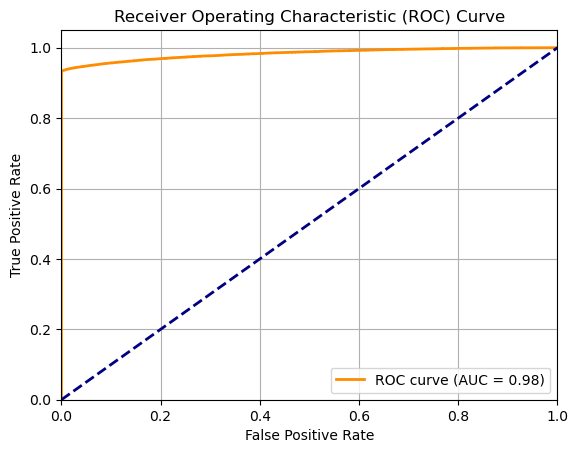

In [40]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# ทำนายความน่าจะเป็น (probabilities)
y_proba = model.predict_proba(X_test)[:, 1]  # ใช้เฉพาะความน่าจะเป็นของ class 1

# คำนวณ fpr, tpr, thresholds สำหรับ ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# คำนวณค่า AUC
roc_auc = auc(fpr, tpr)

# แสดงผล ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # เส้นทำนายแบบสุ่ม
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [46]:
print(appearances_players['performance_class'].value_counts())


performance_class
B    252608
C    153257
A     53847
Name: count, dtype: int64


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# แบ่ง performance_score ออกเป็น 3 กลุ่ม: C (ต่ำ), B (กลาง), A (สูง)
appearances_players['performance_class'] = pd.qcut(
    appearances_players['performance_score'],
    q=3,
    labels=['C', 'B', 'A']
)

# เลือกฟีเจอร์ที่ใช้
features = [
    'z_assists_per_90', 'z_minutes_played_per_90', 'z_yellow_card_per_90',
    'z_red_card_per_90', 'market_value_in_eur', 'season_norm', 'age_score',
    'norm_total_minutes_played', 'experience_score'
]

X = appearances_players[features]
y = appearances_players['performance_class']

# แปลง label 'A', 'B', 'C' เป็นตัวเลข 0, 1, 2
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# แบ่ง train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2)

# สร้างโมเดล XGBoost
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softmax',
    num_class=3
)

# ฝึกโมเดล
model.fit(X_train, y_train)

# ทำนายผล
y_pred = model.predict(X_test)


print("=== Classification Report (Test Set) ===")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))




e:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:57:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           A       0.98      0.51      0.67     10769
           B       0.93      1.00      0.96     50522
           C       0.95      1.00      0.98     30652

    accuracy                           0.94     91943
   macro avg       0.95      0.83      0.87     91943
weighted avg       0.94      0.94      0.93     91943



In [82]:
# สร้างคลาส performance_class แบบกำหนดเอง
def classify_performance(row, thresholds):
    if row['performance_score'] < 0:
        return 'C'
    elif row['avg_performance_score'] <= thresholds[0]:
        return 'C'
    elif row['avg_performance_score'] <= thresholds[1]:
        return 'B'
    else:
        return 'A'

# กำหนด threshold ของ avg_performance_score
q1 = team_layer['avg_performance_score'].quantile(1/3)
q2 = team_layer['avg_performance_score'].quantile(2/3)

# ใช้ฟังก์ชัน classify_performance เพื่อสร้างคอลัมน์ใหม่
team_layer['performance_class'] = team_layer.apply(
    lambda row: classify_performance(row, (q1, q2)), axis=1
)

# แปลง performance_class ให้เป็น string ชัดเจน (กันชนิด float ปะปน)
team_layer['performance_class'] = team_layer['performance_class'].astype(str)

In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier



# เลือกฟีเจอร์ที่ใช้
features = [
    'market_value_in_eur', 'season_year', 'nationality_diversity', 
    'avg_market_value', 'avg_age_team',  
    'avg_experience_score'
]

X = team_layer[features]
y = team_layer['performance_class']

# แปลง label 'A', 'B', 'C' เป็นตัวเลข
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# แบ่งข้อมูลเป็น train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2)

# สร้างโมเดล XGBoost
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softmax',
    num_class=3
)

# ฝึกโมเดล
model.fit(X_train, y_train)

# ทำนายผล
y_pred = model.predict(X_test)

# แปลงผลกลับเป็น label string
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# แสดงผล
print("=== Classification Report (Test Set) ===")
print(classification_report(y_test_labels, y_pred_labels))


e:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:59:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           A       0.98      0.98      0.98    115119
           B       0.97      0.97      0.97    112663
           C       0.97      0.97      0.97    113265

    accuracy                           0.97    341047
   macro avg       0.97      0.97      0.97    341047
weighted avg       0.97      0.97      0.97    341047

